In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import rfft
plt.rcParams["figure.dpi"] = 100

First, we'll define our Gaussian distribution:

In [2]:
def gaussian(x, mu, sig):
    return np.exp(-0.5*((x - mu)/sig)**2)/(sig*np.sqrt(2*np.pi))

A classic pulse profile has $0 \leq \phi \leq 1$. We'll set our center at $\phi = 0.5$ and our peak intensity at a normalized $1$. Since many arrays such as CHIME and MEERKat have 1024 time bins, that's what we'll use.

Text(0.5, 1.0, 'Sample Gaussian Pulse')

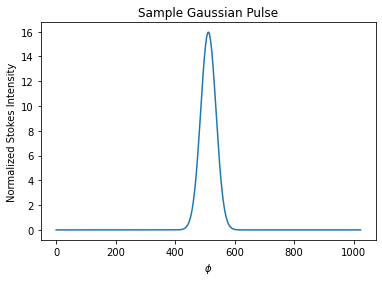

In [3]:
phi_bins = 1024
pulse = gaussian(np.linspace(0, 1, phi_bins), 0.5, 0.025)
plt.plot(pulse)
plt.xlabel(r'$\phi$')
plt.ylabel('Normalized Stokes Intensity')
plt.title('Sample Gaussian Pulse')

Now we'll smear it across different trial DMs by calculating the amount of dispersion it would have at any given DM error. Let's assume some basic quantities of our system...

In [209]:
#frequency range:
f_min = 400 #MHz
f_max = 800 #MHz
#number of frequency channels:
nchans = 1000
#trial DM range:
nDMs = 200
DMs = np.arange(0, nDMs, 1)
#now let's decide the true DM of our pulse is 137
true_DM = 137

In [210]:
def disperse(pulse, trial_DM):
    """This function "dedisperses" a pulse profile according to some error from the true DM.

    Inputs:
    _______
            trial_dm (float)    : test DM

    Returns:
    ________
            dispersed_phase_prof: a DM-smeared 1D phase profile of a pulse
    """

    DM_err = true_DM - trial_DM

    #create frequency array
    freqs = np.linspace(f_min, f_max, nchans, endpoint = False)
    freq_ref = np.max(freqs)

    #define constants
    kDM = 1/(2.41e-4) #in MHz^2 s cm^3 pc^-1
    dt = 2.56*512*0.75*1e-6 #s

    #calculate dispersion delay
    delay = kDM * DM_err * (1/freqs**2 - 1/freq_ref**2)

    #calculate how much to shift bins
    dd_binshift = (delay // dt).astype('int')

    #create 2D pulse profile
    pulse2D = np.zeros((len(freqs), len(pulse)))
    pulse2D[:] = pulse

    #apply dispersion delay to each spectral channel of 2D pulse profile
    for i in range(len(freqs)):
        pulse2D[i] = np.roll(pulse2D[i], dd_binshift[i])

    #average all spectral channels to get 1D dispersed pulse
    dispersed_phase_prof = pulse2D.mean(0)

    return dispersed_phase_prof

Text(0.5, 1.0, 'DM-Smeared Pulse')

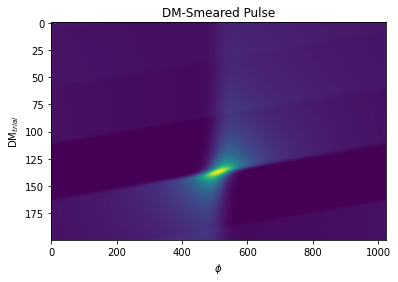

In [211]:
smeared_pulse = np.zeros((len(DMs), phi_bins))
for i in range(len(DMs)):
    smeared_pulse[i] = disperse(pulse, DMs[i])
    
plt.imshow(smeared_pulse, aspect = 'auto')
plt.xlabel(r'$\phi$')
plt.ylabel(r'DM$_{trial}$')
plt.title('DM-Smeared Pulse')

Let's say the true frequency of our pulsar is 25 ms. Then the true bin $r$ at which our first harmonic peak will fall in the system described above is:

In [7]:
true_freq = 25
df = 9.7e-4
true_bin = true_freq/df
true_bin

25773.195876288657

But this isn't a viable, integer bin number. The distribution of power as a function of frequency will follow a sinc function, so we can use that to approximate the power at an adjacent, integer bin $k$ such that:
$$A_{k} = A_{r} \text{ sinc} (\pi*(r - k))$$
$$P_{k} = A_{r}^2 \text{ sinc}^2 (\pi*(r - k))$$

In [54]:
def sinc(x):
    return np.sin(x)/x

Text(0.5, 1.0, 'My Friend the Sinc Function')

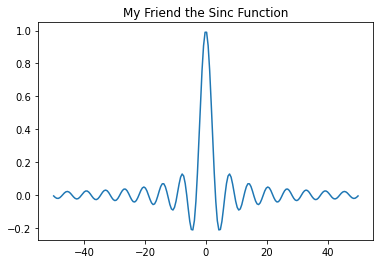

In [112]:
plt.plot(np.linspace(-50, 50, 200), sinc(np.linspace(-50, 50, 200)))
plt.title('My Friend the Sinc Function')

So let's apply the sinc function to calculate the harmonics:

In [199]:
def harmonics(prof, f_true, df):
    
    """This function calculates the array of frequency-domain harmonics for a given pulse profile.

    Inputs:
    _______
            prof (ndarray): pulse phase profile
            f_true (float): true rotational frequency in Hz
            df (float)    : frequency bin width in target spectrum

    Returns:
    ________
            harmonics (ndarray) : Fourier-transformed harmonics of the profile convolved with
                                    [cycles] number of Delta functions
    """
    #currently we are calculating the first 10 harmonics in the 2 bins on either side of the true value (2 + 2 = 4)
    harmonics = np.zeros((40))
    bins = np.zeros((40))

    #take the fft of the pulse
    prof_fft = rfft(prof)
    
    #now evaluate sinc-modified power at each of the first 10 harmonics
    for i in range(1, 11):
        f_harm = i*f_true
        bin_true = f_harm/df
        bin_below = np.floor(bin_true)
        bin_above = np.ceil(bin_true)

        #use 2 bins on either side
        current_bins = np.array([bin_below - 1, bin_below, bin_above, bin_above + 1]).astype(int)
        bins[(i - 1)*4:(i - 1)*4+4] = current_bins
        amplitude = prof_fft[i]*sinc(np.pi*(bin_true - current_bins))
        harmonics[(i - 1)*4:(i - 1)*4+4] = np.abs(amplitude)**2

    return bins.astype(int), harmonics


Text(0.5, 1.0, 'Sinc-Approximated Harmonics of a Single Gaussian')

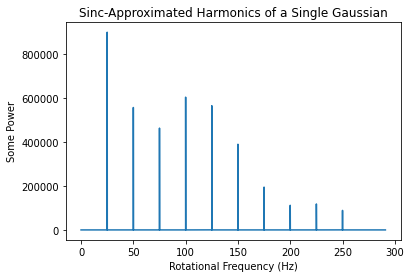

In [207]:
nbins = 300000

bins, harm = harmonics(pulse, true_freq, df)
freq = np.zeros(nbins)
freq[bins] = harm
plt.plot(np.arange(0, nbins, 1)*df, freq)
plt.xlabel('Rotational Frequency (Hz)')
plt.ylabel('Some Power')
plt.title('Sinc-Approximated Harmonics of a Single Gaussian')

The oscillation in power comes from the offset of each harmonic from the nearest integer bin-- the fourth harmonic, for instance, has more power than the 2nd or 3rd because it is closer to an integer bin than either of those, and is therefore modified less from its true power value by the sinc function.
\
\
Now let's call this over our whole smeared pulse.

In [215]:
smeared_harm = np.zeros((nDMs, nbins))
for i in range(len(smeared_pulse)):
    bins, smeared = harmonics(smeared_pulse[i], true_freq, df)
    smeared_harm[i, bins] = smeared

Text(0, 0.5, 'Some Arbitrary Power')

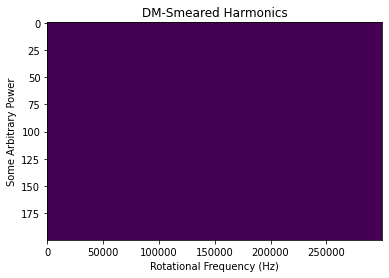

In [221]:
plt.imshow(smeared_harm, aspect = 'auto')
plt.title('DM-Smeared Harmonics')
plt.xlabel('Rotational Frequency (Hz)')
plt.ylabel('Some Arbitrary Power')

We can't see this because the harmonics are so thin relative to the whole power spectrum. Let's zoom in:

Text(0, 0.5, 'Some Arbitrary Power')

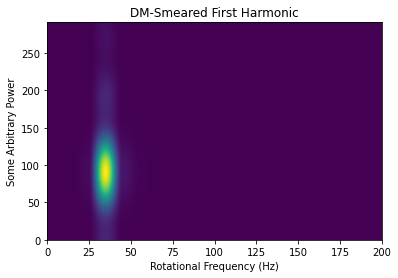

In [220]:
plt.imshow(smeared_harm[:, 25770:25790], extent = [0, nDMs, 0, df*nbins], aspect = 'auto')
plt.title('DM-Smeared First Harmonic')
plt.xlabel('Rotational Frequency (Hz)')
plt.ylabel('Some Arbitrary Power')

...and the second harmonic:

Text(0, 0.5, 'Some Arbitrary Power')

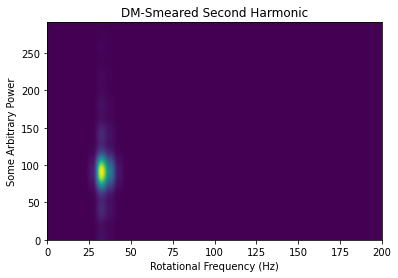

In [222]:
plt.imshow(smeared_harm[:, 2*25770:2*25790], extent = [0, nDMs, 0, df*nbins], aspect = 'auto')
plt.title('DM-Smeared Second Harmonic')
plt.xlabel('Rotational Frequency (Hz)')
plt.ylabel('Some Arbitrary Power')